In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "full"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))
sns.set(font_scale=1.4)

In [2]:
uuid_unique_count_df = df.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

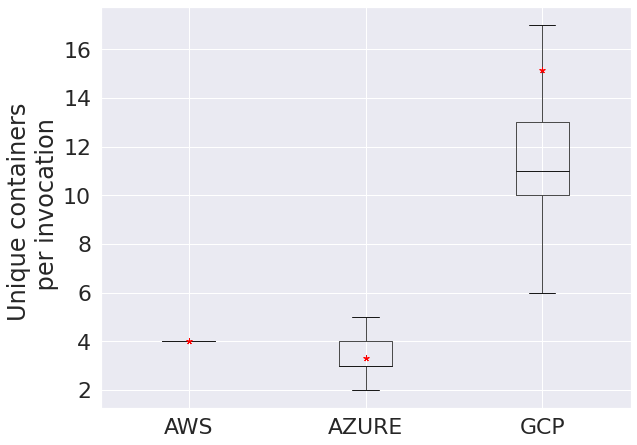

data 
          Unique Container Id                                               \
                       count       mean        std  min   25%   50%   75%   
provider                                                                    
AWS                  28929.0   3.997995   0.095871  3.0   4.0   4.0   4.0   
AZURE                25953.0   3.309059   0.584229  1.0   3.0   3.0   4.0   
GCP                  29006.0  15.166241  14.641359  4.0  10.0  11.0  13.0   

                 
            max  
provider         
AWS         8.0  
AZURE       5.0  
GCP       163.0  


In [3]:
fig, axes = plt.subplots(figsize=(8,6), sharex=True)
sns.set(font_scale=2)
bxdf = uuid_unique_count_df[['provider', 'Unique Container Id']].groupby(['provider'], observed=True)

fig.tight_layout(pad=0)
plt.autoscale()

utils.boxplot(axes, bxdf, "Unique containers \n per invocation", utils.tick_get_1st, with_mean=True)
utils.plot(['provider_analysis_instances', 'pa_instances_unique_containers_per_run'], data=bxdf.describe())

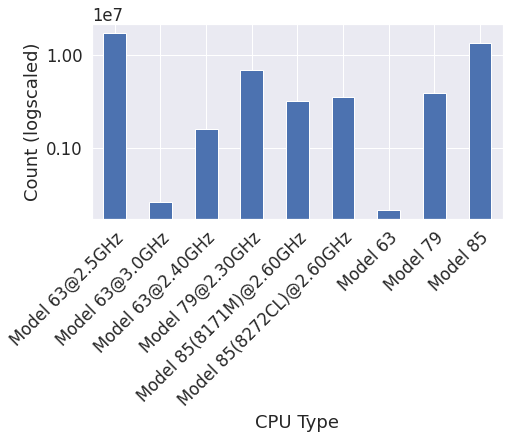

data 
                                                                       workload_invocation
provider cpuModel cpuType                                                                
AWS      63       Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63                17094293
                  Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63                  262384
AZURE    63       Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Mod...              1606859
         79       Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Mod...              6863411
         85       Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz -...              3186542
                  Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz ...              3522172
GCP      63       unknown - Model 63                                               214228
         79       unknown - Model 79                                              3875016
         85       unknown - Model 85                                             13310695


In [4]:
from matplotlib.ticker import ScalarFormatter
sns.set(font_scale=1.5)

cpudf = df[['provider', 'cpuModel', 'cpuType', 'workload_invocation']]
cpu_counts = cpudf.groupby(['provider', 'cpuModel','cpuType'], observed=True)

fig, axes = plt.subplots(figsize=(7,6))
cpu_counts.count().plot(ax=axes, kind='bar')

cpu_type_rewrite = {
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63)": "Model 63@2.5GHz",
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63)" : "Model 63@3.0GHz",
    "(AZURE, 63, Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63)" : "Model 63@2.40GHz",
    "(AZURE, 79, Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79)" : "Model 79@2.30GHz",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85)" : "Model 85(8171M)@2.60GHz",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85)" : "Model 85(8272CL)@2.60GHz",
    "(GCP, 63, unknown - Model 63)" : "Model 63",
    "(GCP, 79, unknown - Model 79)" : "Model 79",
    "(GCP, 85, unknown - Model 85)" : "Model 85",
}

labels = []
for tick in axes.get_xticklabels():
    if tick.get_text() in cpu_type_rewrite.keys():
        labels.append(cpu_type_rewrite[tick.get_text()])
    else:
        labels.append(tick.get_text())
    
axes.set_xlabel('CPU Type')      
axes.set_ylabel('Count (logscaled)')
axes.set_xticklabels(labels)
axes.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

# plt.setp(axes.get_xticklabels(), rotation=0)
axes.get_legend().remove()
axes.set_yscale('log')
axes.yaxis.set_major_formatter(ScalarFormatter())

fig.tight_layout(pad=0.2)
utils.plot(['provider_analysis_instances', 'pa_instances_cputype'], data=cpu_counts.count())

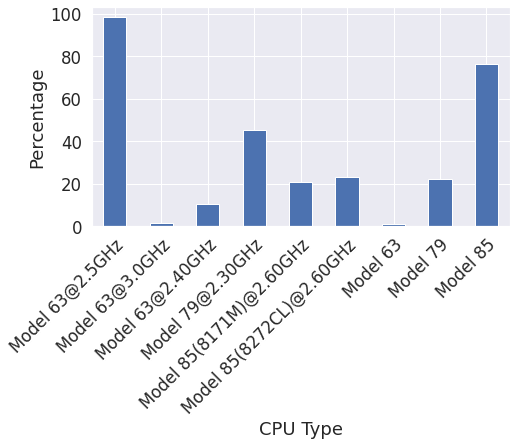

data 
                                                                       workload_invocation
provider cpuModel cpuType                                                                
AWS      63       Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63               98.488282
                  Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63                1.511718
AZURE    63       Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Mod...            10.586077
         79       Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Mod...            45.216538
         85       Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz -...            20.993118
                  Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz ...            23.204267
GCP      63       unknown - Model 63                                             1.231200
         79       unknown - Model 79                                            22.270285
         85       unknown - Model 85                                            76.498515


In [7]:
from matplotlib.ticker import ScalarFormatter
sns.set(font_scale=1.5)

cpudf = df[['provider', 'cpuModel', 'cpuType', 'workload_invocation']]
cpu_counts = cpudf.groupby(['provider', 'cpuModel','cpuType'], observed=True)
cpu_counts_total = pd.DataFrame(cpu_counts.count().groupby('provider', group_keys=False).apply(lambda df: (df['workload_invocation'] / df['workload_invocation'].sum()) * 100) )

fig, axes = plt.subplots(figsize=(7,6))
# cpu_counts.count().plot(ax=axes, kind='bar')
cpu_counts_total.plot(ax=axes, kind='bar')

cpu_type_rewrite = {
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63)": "Model 63@2.5GHz",
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63)" : "Model 63@3.0GHz",
    "(AZURE, 63, Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63)" : "Model 63@2.40GHz",
    "(AZURE, 79, Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79)" : "Model 79@2.30GHz",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85)" : "Model 85(8171M)@2.60GHz",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85)" : "Model 85(8272CL)@2.60GHz",
    "(GCP, 63, unknown - Model 63)" : "Model 63",
    "(GCP, 79, unknown - Model 79)" : "Model 79",
    "(GCP, 85, unknown - Model 85)" : "Model 85",
}

labels = []
for tick in axes.get_xticklabels():
    if tick.get_text() in cpu_type_rewrite.keys():
        labels.append(cpu_type_rewrite[tick.get_text()])
    else:
        labels.append(tick.get_text())
    
axes.set_xlabel('CPU Type')      
axes.set_ylabel('Percentage')
axes.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
axes.get_legend().remove()

axes.yaxis.set_major_formatter(ScalarFormatter())

fig.tight_layout(pad=0)
utils.plot(['provider_analysis_instances', 'pa_instances_cputype_percentage'], data=cpu_counts_total)

Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63
Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63
Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63
Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79
Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85
Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85
unknown - Model 63
unknown - Model 79
unknown - Model 85


/tmp/ipykernel_2010/1317340769.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=45, ha="right", rotation_mode="anchor")


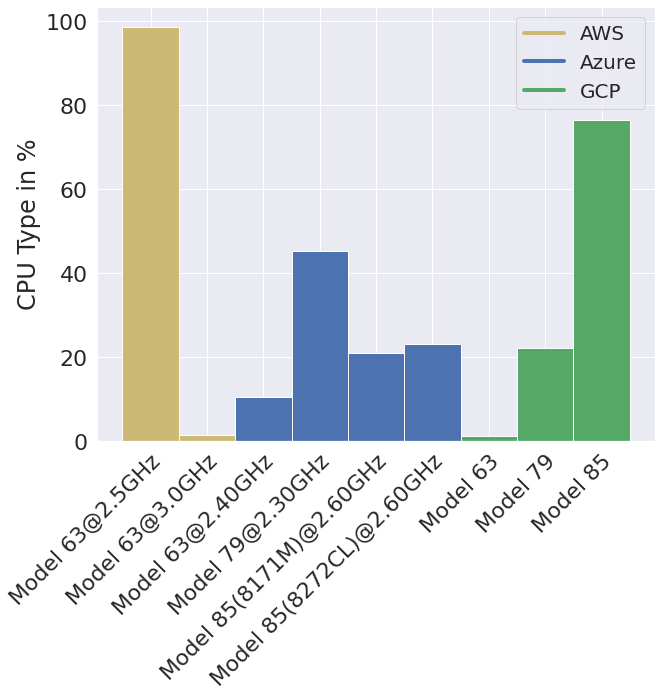

data 
                                                                       workload_invocation
provider cpuModel cpuType                                                                
AWS      63       Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63               98.488282
                  Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63                1.511718
AZURE    63       Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Mod...            10.586077
         79       Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Mod...            45.216538
         85       Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz -...            20.993118
                  Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz ...            23.204267
GCP      63       unknown - Model 63                                             1.231200
         79       unknown - Model 79                                            22.270285
         85       unknown - Model 85                                            76.498515


In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=2)
w = 1
x= 0
ticks = []
labels = []

cpu_type_rewrite = {
    "Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Model 63@2.5GHz",
    "Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63" : "Model 63@3.0GHz",
    "Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63" : "Model 63@2.40GHz",
    "Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79" : "Model 79@2.30GHz",
    "Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85" : "Model 85(8171M)@2.60GHz",
    "Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85" : "Model 85(8272CL)@2.60GHz",
    "unknown - Model 63" : "Model 63",
    "unknown - Model 79" : "Model 79",
    "unknown - Model 85" : "Model 85",
}

for index, row in cpu_counts_total.reset_index().iterrows():
    p = row['provider']
    cputype = row['cpuType']
    c = 'black'
    if p == 'AWS':
        c = 'y'
    if p == 'AZURE':
        c = 'b'    
    if p == 'GCP':
        c = 'g'
    x +=1
    ticks.append(x)
    labels.append(cputype)
    ax.bar(cputype, row['workload_invocation'], w, label=p, color = c)

new_labels = []
for l in labels:
    print(l)
    if l in cpu_type_rewrite.keys():
        new_labels.append(cpu_type_rewrite[l])
    else:
        new_labels.append(l)

# ax.set_xlabel('CPU Type')      
ax.set_ylabel('CPU Type in %')
ax.set_xticklabels(new_labels, rotation=45, ha="right", rotation_mode="anchor")

    
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='y', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]
ax.legend(custom_lines, ['AWS', 'Azure', 'GCP'], fontsize='small')
utils.plot(['provider_analysis_instances', 'pa_instances_cputype_percentage_custom'], data=cpu_counts_total)

In [ ]:
cpu_count_df = df.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index(name='Unique CPU Types')
sns.set(font_scale=2)

fig, axes = plt.subplots(figsize=(8,6))
fig.tight_layout(pad=0)

bxdf = cpu_count_df.groupby(['provider'])
utils.boxplot(axes, bxdf, "CPU types \n used per invocation", utils.tick_get_1st, with_mean=True)
utils.plot(['provider_analysis_instances', 'pa_instance_cpus_types_per_invocation'], data=bxdf.describe())

In [ ]:
df_ct = df[['driver_invocation', 'provider', 'runtime', 'cpuType']]
df_mean_per_ct = df_ct.groupby(['driver_invocation', 'provider', 'cpuType'], observed=True).mean().reset_index()

label_rewrite = {
    "runtime" : "runtime",
    "cpuType_Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Xeon @ 2.5GHz\n(Model 63)",
    "cpuType_Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63" : "Xeon @ 3.0GHz\n(Model 63)",
    "cpuType_Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63" : "Xeon \nE5-2673 v3\n@2.40GHz (Model 63)",
    "cpuType_Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79" : "Xeon \nE5-2673 v4\n@2.30GHz (Model 79)",
    "cpuType_Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85" : "Xeon Platinum 8171M\n@2.60GHz (Model 85)",
    "cpuType_Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85" : "Xeon Platinum 8272CL\n@2.60GHz (Model 85)",
    "cpuType_unknown - Model 63" : "Model 63",
    "cpuType_unknown - Model 79" : "Model 79",
    "cpuType_unknown - Model 85" : "Model 85",
}

for p in ['AWS', 'AZURE', 'GCP']:
        pdf = df_mean_per_ct[df_mean_per_ct['provider'] == p]
        cols = [ f"cpuType_{c}" for c in list(pdf['cpuType'].unique())]
        cols = ['runtime'] + cols
        dummydf = pd.get_dummies(pdf[['runtime', 'cpuType']], 'cpuType')[cols]
        fig, axes = plt.subplots(figsize=(4,4))
        
        heatmap = sns.heatmap(dummydf.corr(), annot=True)
        heatmap.set_xticklabels([label_rewrite[l.get_text()] for l in heatmap.get_xticklabels()]) 
        heatmap.set_yticklabels([label_rewrite[l.get_text()] for l in heatmap.get_yticklabels()])
        utils.plot(['provider_analysis_instances', f'pa_instance_cpus_types_runtime_invocation_{p}'], data=dummydf.corr())

In [ ]:
def process_linux_version(row):    
    if (row['provider'] == 'AWS'):
        val = row['linuxVersion']
        xpos = val.find(" ", 6)
        val = val[xpos+1:]
        row['linuxVersion'] = val
    elif (row['provider'] == 'AZURE'):
        val = row['linuxVersion']
        xpos = val.find(" ", 6)
        val = val[xpos+1:]
        row['linuxVersion'] = val
    elif (row['provider'] == 'GCP'):
        pass
    else:
        raise Exception("Error Processing Linux Version")
    return row

import swifter
df_linux = df[['workload_invocation','provider', 'linuxVersion']].swifter.apply(process_linux_version, axis=1)

In [ ]:
# Count different version on workload invocations.
df_linux.groupby(['provider', 'linuxVersion']).nunique()